In [1]:
import pandas as pd
import os
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from pandas import read_csv
import shapely.wkt
import geopandas as gpd
import contextily as cx
import warnings
from shapely.geometry import box
import matplotlib

warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/MFD/visualization')

plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font
Output_dir = 'Output/'
mile_to_meter = 1609.3435021075907
mile_to_km = 1.60934

<Axes: >

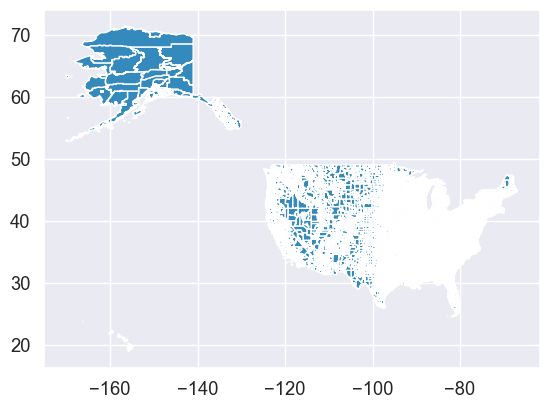

In [2]:
# load us map
us_tract_gdf = gpd.read_file('census_tracts_2017.geojson')
polygon = box(-170, 10, -66.96466, 71.365162)
us_tract_clipped = us_tract_gdf.clip(polygon)
us_tract_clipped.plot()

In [3]:
us_tract_clipped.head(5)

,GEOID,NAME,geometry
62375,48061013309,"Census Tract 133.09, Cameron County, Texas","POLYGON ((-97.44449 25.87977, -97.44376 25.881..."
62373,48061013307,"Census Tract 133.07, Cameron County, Texas","POLYGON ((-97.48884 25.89419, -97.48706 25.894..."
62374,48061013308,"Census Tract 133.08, Cameron County, Texas","POLYGON ((-97.45032 25.89065, -97.44880 25.891..."
62388,48061014100,"Census Tract 141, Cameron County, Texas","POLYGON ((-97.45618 25.87332, -97.45311 25.872..."
62386,48061014001,"Census Tract 140.01, Cameron County, Texas","POLYGON ((-97.50866 25.90346, -97.50448 25.899..."


In [10]:
# load here data and microtype lookup
microtype_lookup = read_csv('ccst_geoid_key_transp_geo_with_imputation.csv')
print(microtype_lookup.columns)
here_density_and_speed = read_csv('tract_peak_ds_sample.csv')
here_density_and_speed.head(5)

Index(['FID', 'GEOID', 'MicrotypeID', 'microtype', 'microtype_imp', 'fips_st',
       'st_code', 'state', 'cty', 'ctyname', 'cbsa', 'cbsaname', 'spatial_id',
       'geotype', 'geotype_imp'],
      dtype='object')


,tract_geoid,microtype,state,cnt_tmcs,avg_density_plm_am,avg_density_plm_pm,avg_density_plm_day,avg_speed_mph_am,avg_speed_mph_pm,avg_speed_mph_day
0,6001400100,5,CA,13.981914,13.089073,15.372559,14.230413,22.011073,22.439350,22.225136
1,6001400200,2,CA,11.979968,9.782347,11.888233,10.838245,18.037875,17.509818,17.773105
2,6001400300,3,CA,35.722527,15.533010,24.363995,19.914418,41.766762,35.848868,38.830656
3,6001400400,1,CA,9.975962,16.128154,22.439294,19.275933,20.806291,19.875997,20.342293
4,6001400500,1,CA,6.770375,25.222648,20.859559,23.017383,19.437050,18.525808,18.976475


In [11]:
# merge data
microtype_lookup.loc[:, 'GEOID'] = \
microtype_lookup.loc[:, 'GEOID'].astype(str).str.zfill(11)

here_density_and_speed.loc[:, 'tract_geoid'] = \
here_density_and_speed.loc[:, 'tract_geoid'].astype(str).str.zfill(11)

microtype_lookup = microtype_lookup.loc[microtype_lookup['st_code'] == 'CA'] # Checking CA results
print(len(microtype_lookup))
microtype_lookup_short = \
microtype_lookup[['GEOID', 'cty', 'ctyname', 'cbsa', 'cbsaname', 'geotype']]
# microtype_lookup_short
print(len(here_density_and_speed))
here_density_and_speed = pd.merge(here_density_and_speed,
                                  microtype_lookup_short,
                                  left_on = 'tract_geoid',
                                  right_on = 'GEOID',
                                  how = 'left')
here_density_and_speed = here_density_and_speed.drop(columns = ['tract_geoid'])
here_density_and_speed.head(5)

8038
6585


,microtype,state,cnt_tmcs,avg_density_plm_am,avg_density_plm_pm,avg_density_plm_day,avg_speed_mph_am,avg_speed_mph_pm,avg_speed_mph_day,GEOID,cty,ctyname,cbsa,cbsaname,geotype
0,5,CA,13.981914,13.089073,15.372559,14.230413,22.011073,22.439350,22.225136,06001400100,6001,"Alameda County, CA",41860,"San Francisco-Oakland-Hayward, CA",A
1,2,CA,11.979968,9.782347,11.888233,10.838245,18.037875,17.509818,17.773105,06001400200,6001,"Alameda County, CA",41860,"San Francisco-Oakland-Hayward, CA",A
2,3,CA,35.722527,15.533010,24.363995,19.914418,41.766762,35.848868,38.830656,06001400300,6001,"Alameda County, CA",41860,"San Francisco-Oakland-Hayward, CA",A
3,1,CA,9.975962,16.128154,22.439294,19.275933,20.806291,19.875997,20.342293,06001400400,6001,"Alameda County, CA",41860,"San Francisco-Oakland-Hayward, CA",A
4,1,CA,6.770375,25.222648,20.859559,23.017383,19.437050,18.525808,18.976475,06001400500,6001,"Alameda County, CA",41860,"San Francisco-Oakland-Hayward, CA",A


1357


<Axes: >

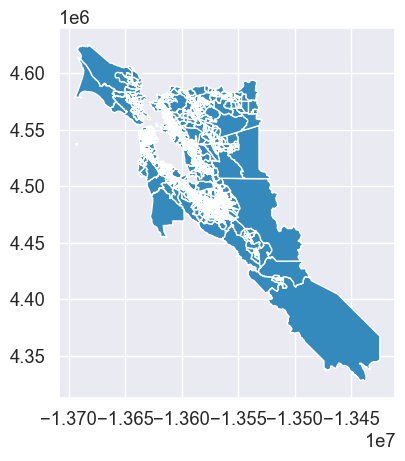

In [19]:
# plot SF speed
cbsas = [41860, 41940]
cbsa_tracts = microtype_lookup.loc[microtype_lookup['cbsa'].isin(cbsas), 'GEOID'].unique()
print(len(cbsa_tracts))
us_tract_clipped.loc[:, 'GEOID'] = us_tract_clipped.loc[:, 'GEOID'].astype(str).str.zfill(11)
us_tract_in_cbsa = us_tract_clipped.loc[us_tract_clipped['GEOID'].isin(cbsa_tracts)]
us_tract_in_cbsa = us_tract_in_cbsa.to_crs(epsg=3857)
us_tract_in_cbsa.plot()

In [20]:
us_tract_in_cbsa = us_tract_in_cbsa.merge(here_density_and_speed,
                                          on = 'GEOID',
                                          how = 'left')
us_tract_in_cbsa.head(5)

,GEOID,NAME,geometry,microtype,state,cnt_tmcs,avg_density_plm_am,avg_density_plm_pm,avg_density_plm_day,avg_speed_mph_am,avg_speed_mph_pm,avg_speed_mph_day,cty,ctyname,cbsa,cbsaname,geotype
0,06081613700,"Census Tract 6137, San Mateo County, California","POLYGON ((-13629319.886 4503999.669, -13629243...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06081608900,"Census Tract 6089, San Mateo County, California","POLYGON ((-13617777.551 4510750.432, -13617735...",3.0,CA,27.990385,10.225056,11.872265,11.049523,50.007379,51.374909,50.691860,6081.0,"San Mateo County, CA",41860.0,"San Francisco-Oakland-Hayward, CA",A
2,06081608800,"Census Tract 6088, San Mateo County, California","POLYGON ((-13617138.241 4511484.701, -13617251...",2.0,CA,5.997482,8.804914,9.478616,9.141413,27.141273,27.712985,27.426830,6081.0,"San Mateo County, CA",41860.0,"San Francisco-Oakland-Hayward, CA",A
3,06081613502,"Census Tract 6135.02, San Mateo County, Califo...","POLYGON ((-13636917.105 4512443.794, -13636661...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06081606900,"Census Tract 6069, San Mateo County, California","POLYGON ((-13620935.249 4513236.286, -13620129...",3.0,CA,25.981113,11.389961,15.935374,13.661076,50.996851,47.726790,49.362966,6081.0,"San Mateo County, CA",41860.0,"San Francisco-Oakland-Hayward, CA",A


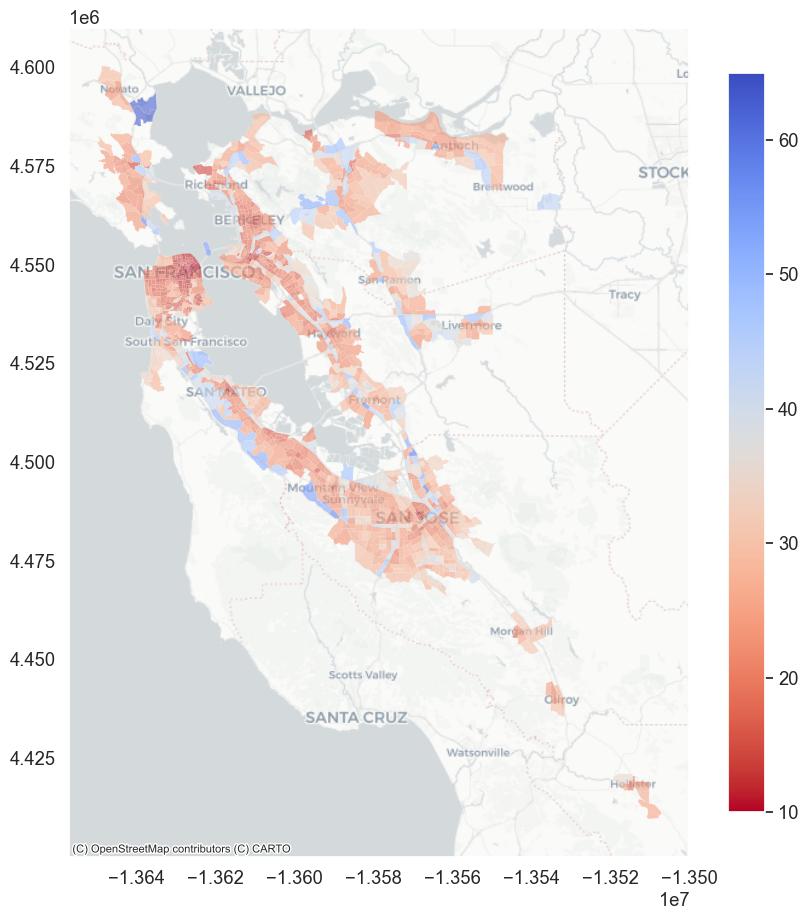

In [21]:
ax = us_tract_in_cbsa.plot(figsize = (10,12), 
                      column = 'avg_speed_mph_am', 
                      cmap='coolwarm_r',
                      alpha = 0.6, 
                      vmin = 10, vmax = 65,
                      linewidth=0.1, legend=True,
                      legend_kwds = {'shrink': 0.8})
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.grid(False)
plt.savefig('plots/avg_speed_tract_am.png', dpi = 200)

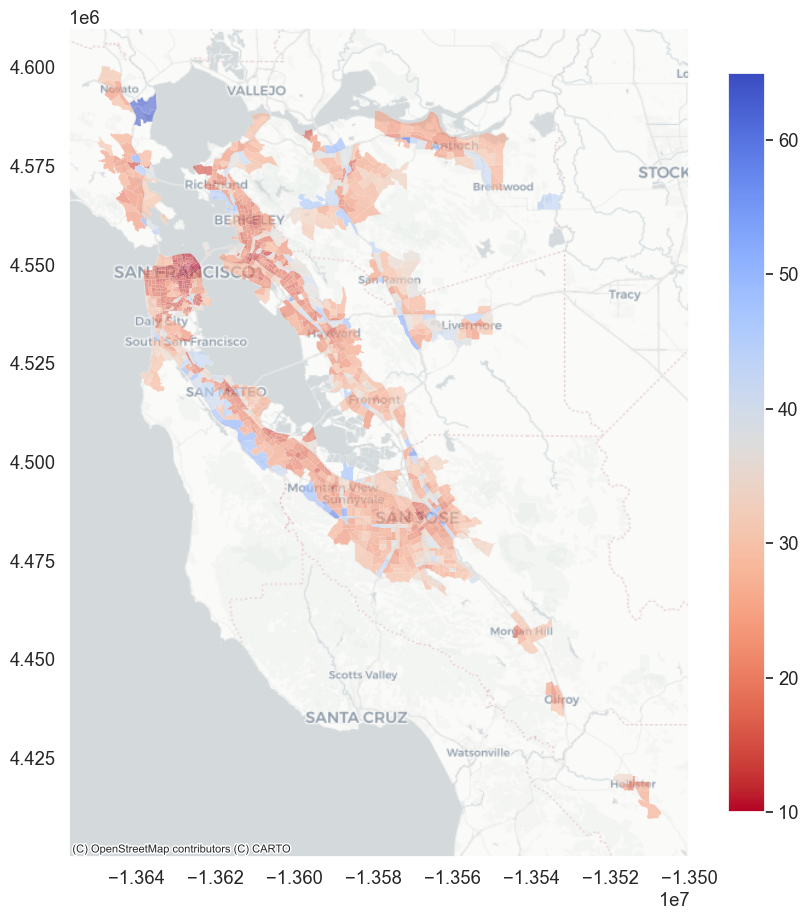

In [22]:
ax = us_tract_in_cbsa.plot(figsize = (10,12), 
                      column = 'avg_speed_mph_pm', 
                      cmap='coolwarm_r',
                      alpha = 0.6, 
                      vmin = 10, vmax = 65,
                      linewidth=0.1, legend=True,
                      legend_kwds = {'shrink': 0.8})
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.grid(False)
plt.savefig('plots/avg_speed_tract_pm.png', dpi = 200)

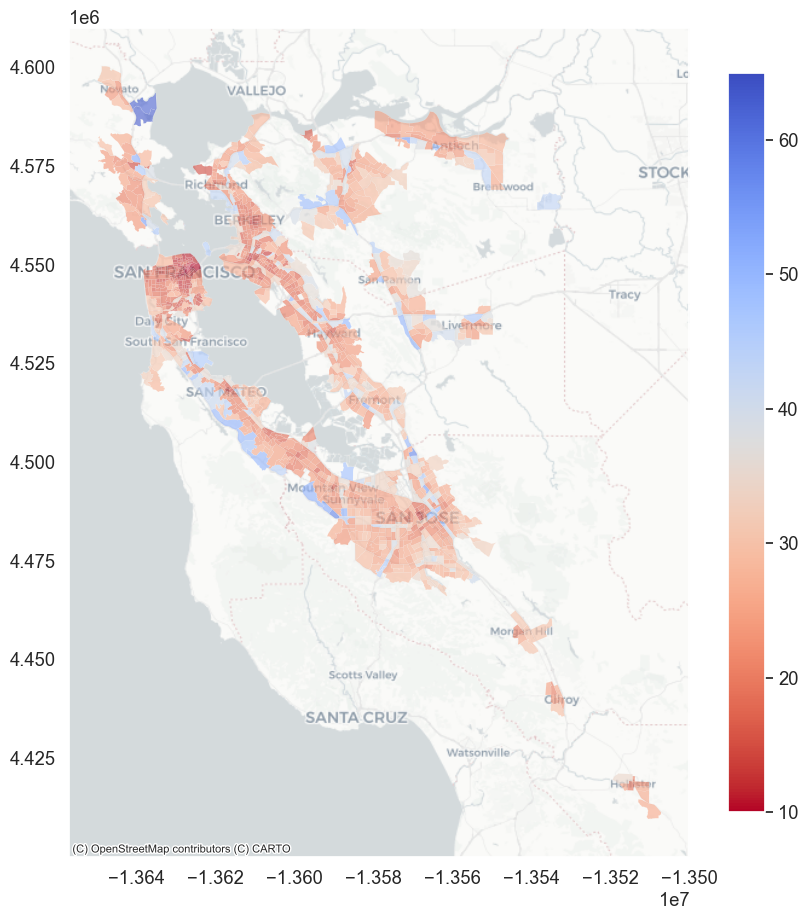

In [23]:
ax = us_tract_in_cbsa.plot(figsize = (10,12), 
                      column = 'avg_speed_mph_day', 
                      cmap='coolwarm_r',
                      alpha = 0.6, 
                      vmin = 10, vmax = 65,
                      linewidth=0.1, legend=True,
                      legend_kwds = {'shrink': 0.8})
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron)
ax.grid(False)
plt.savefig('plots/avg_speed_tract_day.png', dpi = 200)

In [24]:
us_tract_in_cbsa_df = pd.DataFrame(us_tract_in_cbsa.drop(columns='geometry'))

us_tract_in_cbsa_df.to_csv('plots/here_density_speed_sf.csv')